In [1]:
import warnings
warnings.filterwarnings('ignore')

import urllib, json
from urllib.request import urlopen
import numpy as np
from io import open
import ast
import time
import requests
import pandas as pd

from IPython.core.display import HTML,display
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


from collections import Counter

import networkx as nx
from itertools import combinations

import random



In [2]:
works = np.load("w_um.npy", allow_pickle=True)
start_year = 2004
end_year = 2008

In [3]:
def build_coauthorship_network(works, institution_name, start_year, end_year):
    """
    Constructs a co-authorship network for the specified time window.
    Nodes represent authors affiliated with the given institution.
    Edges indicate that two authors have collaborated on at least one publication
    within the specified time window, with an optional weight representing
    the number of collaborations.
    """
    G = nx.Graph()
    
    # Iterate through works within the time window
    for work in works:
        pub_year = work["publication_year"]
        if start_year <= pub_year <= end_year:
            authors = []
            for author in work["authorships"]:
                if "institutions" in author:
                    for institution in author["institutions"]:
                        if institution["display_name"] == institution_name:
                            authors.append(author["author"]["display_name"])
                            break  # once matched, no need to check further institutions
            # Only consider works with at least one author from the institution
            unique_authors = set(authors)
            if unique_authors:
                # Add nodes for each author
                for author in unique_authors:
                    G.add_node(author)
                # Add edges between every pair of authors (co-authorship ties)
                for a, b in combinations(unique_authors, 2):
                    if G.has_edge(a, b):
                        G[a][b]['weight'] += 1
                    else:
                        G.add_edge(a, b, weight=1)
    return G

def compute_network_metrics(G):
    """
    Computes a set of network metrics for the given graph G, including:
      - Number of nodes (authors)
      - Number of edges (co-authorship ties)
      - Network density
      - Average degree (number of collaborations per author)
      - Average clustering coefficient (tendency of collaborators to collaborate with each other)
      - Size of the largest connected component (largest cohesive group)
    """
    metrics = {}
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    
    # Compute average degree
    if G.number_of_nodes() > 0:
        degrees = dict(G.degree())
        metrics['avg_degree'] = sum(degrees.values()) / G.number_of_nodes()
    else:
        metrics['avg_degree'] = 0
    
    # Compute average clustering coefficient
    metrics['avg_clustering'] = nx.average_clustering(G)
    
    # Compute the largest connected component
    if G.number_of_nodes() > 0:
        # Get all connected components (each as a set of nodes)
        connected_components = list(nx.connected_components(G))
        # Identify the largest connected component by size
        largest_cc = max(connected_components, key=len)
        metrics['largest_cc_size'] = len(largest_cc)
        # Alternatively, you can create a subgraph of the largest connected component:
        largest_cc_subgraph = G.subgraph(largest_cc).copy()
        metrics['largest_cc_subgraph'] = largest_cc_subgraph
    else:
        metrics['largest_cc_size'] = 0
        metrics['largest_cc_subgraph'] = None
        
    return metrics

# Example usage for a 5-year window:
start_year = 2018
end_year = 2023
G_window = build_coauthorship_network(works, "University of Maribor", start_year, end_year)
network_metrics = compute_network_metrics(G_window)

print("Network metrics for {}–{}:".format(start_year, end_year))
for key, value in network_metrics.items():
    if key != 'largest_cc_subgraph':
        print(f"  {key}: {value}")

# Optionally, if you want to analyze the largest connected component further:
largest_cc_graph = network_metrics['largest_cc_subgraph']
if largest_cc_graph:
    print("  The largest connected component has {} nodes.".format(largest_cc_graph.number_of_nodes()))


Network metrics for 2018–2023:
  num_nodes: 3060
  num_edges: 10798
  density: 0.0023071318535041784
  avg_degree: 7.057516339869281
  avg_clustering: 0.6032562017694004
  largest_cc_size: 2356
  The largest connected component has 2356 nodes.


In [17]:
def rewire_network(G, nswap_multiplier=10, seed=42):
    """
    Creates a rewired version of G by performing a double-edge swap,
    which randomizes the network while preserving the degree sequence.
    
    Parameters:
      G: The original network (NetworkX Graph).
      nswap_multiplier: Determines the number of swaps as (nswap_multiplier * number_of_edges).
      seed: Random seed for reproducibility.
    
    Returns:
      G_rand: The rewired (randomized) network.
    """
    G_rand = G.copy()
    num_edges = G_rand.number_of_edges()
    nswap = nswap_multiplier * num_edges
    try:
        nx.double_edge_swap(G_rand, nswap=nswap, max_tries=nswap * 10, seed=seed)
    except Exception as e:
        print("Double edge swap encountered an error:", e)
    return G_rand

def random_rewire(G, nm=0.1):
    """
    Randomly rewires a fraction of edges in the undirected graph G.
    Removes n = nm * number_of_edges(G) edges at random, then adds
    back n edges between random node pairs, avoiding duplicates.
    
    :param G:   A NetworkX undirected graph.
    :param nm:  Fraction of edges to rewire (0 <= nm <= 1 or more).
    :return:    The rewired graph (done in-place).
    """
    # Number of edges to rewire
    n = int(nm * G.number_of_edges())
    if n <= 0:
        return G  # nothing to do if nm too small or G is small
    
    edges = list(G.edges())
    
    # 1) Remove n edges at random
    edges_to_remove = random.sample(edges, k=n)
    G.remove_edges_from(edges_to_remove)
    
    # 2) Add n edges between random node pairs (avoiding duplicates/self-loops)
    new_edges = set()
    nodes = list(G.nodes())
    
    while len(new_edges) < n:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in new_edges and (v, u) not in new_edges:
            new_edges.add((u, v))
    
    G.add_edges_from(new_edges)
    return G

In [22]:
nm = 1.0
c = []
c_rand1 = []
c_rand2 = []
r = []
r_rand1 = []
r_rand2 = []
for year in range(2004, 2019):
    G = build_coauthorship_network(works, "University of Maribor", year, year+5)
    seed = np.random.randint(0, 2**32 - 1)
    G1 = G.copy()
    G2 = G.copy()
    G1_rand = rewire_network(G1, nswap_multiplier=nm, seed=seed)
    G2_rand = random_rewire(G2, nm=nm)
    # get largest connected component as subgraph
    largest_cc = max(nx.connected_components(G), key=len)
    # assortativity of largest connected component
    assortativity_lc = nx.degree_assortativity_coefficient(G, nodes=largest_cc)
    G_lcc = G.subgraph(largest_cc).copy()
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    network_metrics = compute_network_metrics(G)
    print(f"{year+5}: {network_metrics['largest_cc_size']/network_metrics['num_nodes'], 
        network_metrics['avg_degree'], network_metrics['avg_clustering'], assortativity_lc, avg_path_length}")

    c.append(network_metrics['avg_clustering'])
    r.append(assortativity_lc)

    # assortativity of largest connected component
    assortativity_lc = nx.degree_assortativity_coefficient(G1_rand, nodes=largest_cc)
    largest_cc = max(nx.connected_components(G1_rand), key=len)
    G_lcc = G1_rand.subgraph(largest_cc).copy()
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    network_metrics = compute_network_metrics(G1_rand)
    print(f"{year+5}: {network_metrics['largest_cc_size']/network_metrics['num_nodes'], 
        network_metrics['avg_degree'], network_metrics['avg_clustering'], assortativity_lc, avg_path_length}")

    c_rand1.append(network_metrics['avg_clustering'])
    r_rand1.append(assortativity_lc)

    # assortativity of largest connected component
    assortativity_lc = nx.degree_assortativity_coefficient(G2_rand, nodes=largest_cc)
    largest_cc = max(nx.connected_components(G2_rand), key=len)
    G_lcc = G2_rand.subgraph(largest_cc).copy()
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    network_metrics = compute_network_metrics(G2_rand)
    print(f"{year+5}: {network_metrics['largest_cc_size']/network_metrics['num_nodes'], 
        network_metrics['avg_degree'], network_metrics['avg_clustering'], assortativity_lc, avg_path_length}")

    c_rand2.append(network_metrics['avg_clustering'])
    r_rand2.append(assortativity_lc)

    print("###################################################################################################", network_metrics['avg_degree']/G.number_of_nodes())




2009: (0.6628440366972477, 3.685015290519878, 0.5013247743946363, -0.03821406752759069, 7.908023472940324)
2009: (0.841743119266055, 3.685015290519878, 0.009253721127611332, -0.0051127685772219085, 4.597843282965899)
2009: (0.9709480122324159, 3.685015290519878, 0.00291005291005291, 0.021472201768395524, 5.580474426512289)
################################################################################################### 0.0028172899774616803
2010: (0.6791255289139634, 3.755994358251058, 0.5180674595036716, -0.05408120461384552, 7.694887554700639)
2010: (0.847672778561354, 3.755994358251058, 0.008853890921628553, -0.00036857788457269345, 4.480829203617064)
2010: (0.9710860366713682, 3.755994358251058, 0.00166845769807688, -0.0021107074895372734, 5.557943203121042)
################################################################################################### 0.0026487971496833977
2011: (0.6664420485175202, 3.756064690026954, 0.5169526839573563, -0.06385732815476981, 7.1918840033895

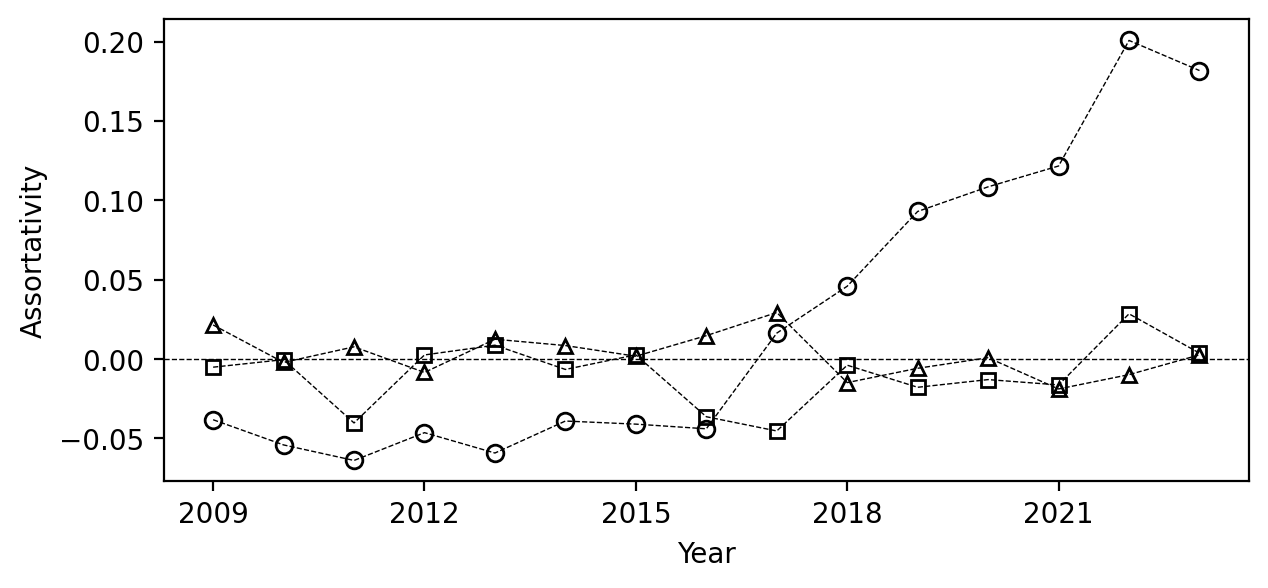

In [39]:
# plot c and r
xx = [year+5 for year in range(2004, 2019)]
plt.figure(figsize=(7, 3))
#plt.plot(xx,c, label='Original', color='black', linestyle='dashed', linewidth=0.5, marker='o', markersize=6, mfc="none")
plt.plot(xx,r, label='Original', color='black', linestyle='dashed', linewidth=0.5, marker='o', markersize=6, mfc="none")
plt.plot(xx,r_rand1, label='Randomized 1', color='black', linestyle='dashed', linewidth=0.5, marker='s', markersize=5, mfc="none")
plt.plot(xx,r_rand2, label='Randomized 2', color='black', linestyle='dashed', linewidth=0.5, marker='^', markersize=5, mfc="none")
# x ticks every 3 years
plt.xticks(np.arange(2009, 2023, 3))
plt.xlabel('Year')
plt.ylabel('Assortativity')
# add y=0 line dashed
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.5)



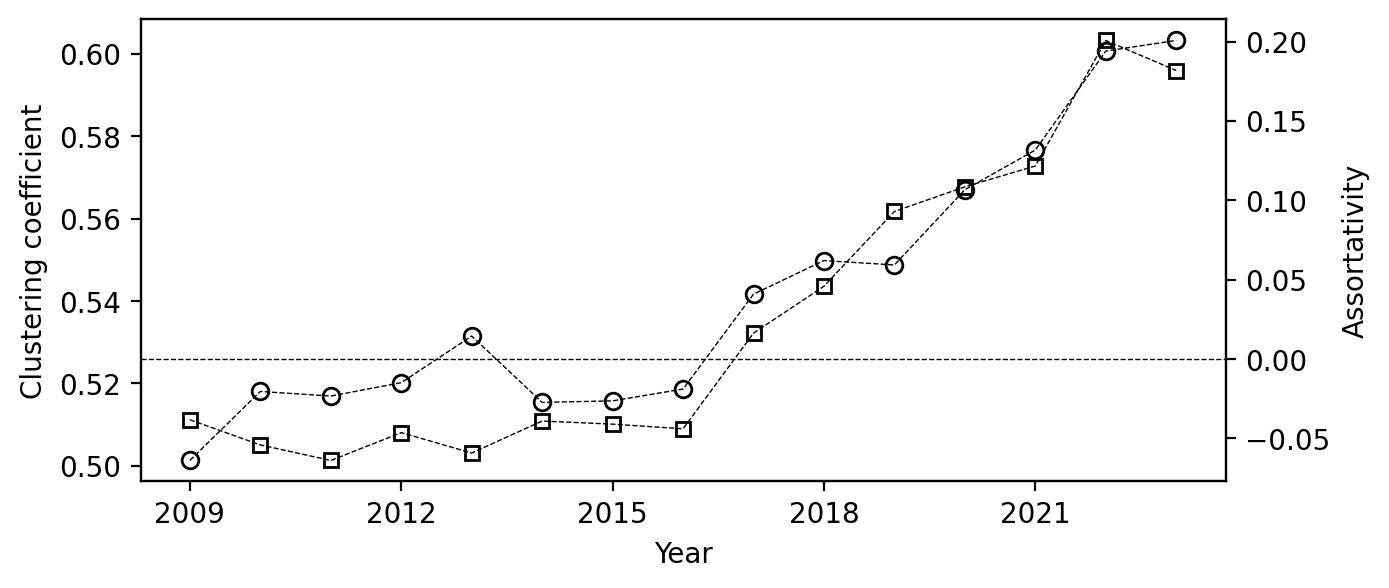

In [35]:
# plot c and r on the same plot with two y-axes
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
ax1.plot(xx, c, label='Clustering coefficient', color='black', linestyle='dashed', linewidth=0.5, marker='o', markersize=6, mfc="none")
ax2.plot(xx, r, label='Assortativity', color='black', linestyle='dashed', linewidth=0.5, marker='s', markersize=5, mfc="none")
#ax2.plot(xx, r_rand1, label='Assortativity (rewired 1)', color='blue', linestyle='dashed', linewidth=0.5, marker='s', markersize=5, mfc="none")
#ax2.plot(xx, r_rand2, label='Assortativity (rewired 2)', color='red', linestyle='dashed', linewidth=0.5, marker='s', markersize=5, mfc="none")
# x ticks every 3 years
plt.xticks(np.arange(2009, 2023, 3))
ax1.set_xlabel('Year')
ax1.set_ylabel('Clustering coefficient')
ax2.set_ylabel('Assortativity')
# add y=0 line dashed
ax2.axhline(0, color='black', linestyle='dashed', linewidth=0.5)

In [40]:
um_staff = {2004:798, 2005:934, 2006: 1022, 2007: 1037, 2008: 1040, 2009: 923, 2010: 865, 2011: 907, 2012: 869, 2013: 860,
            2014: 871, 2015: 889, 2016: 888, 2017: 908, 2018: 915, 2019: 940, 2020: 940, 2021: 960, 2022: 977, 2023: 1004}

um_skupina_H = {2005: 181, 2006: 240, 2007: 228, 2008: 234, 2009: 207, 2010: 238, 2011: 244, 2012: 210, 2013: 211, 2014: 175, 2015: 149, 
                2016: 159, 2017: 184, 2018: 219, 2019: 289, 2020: 289, 2021: 296, 2022: 262, 2023: 303}

um_research = {k: um_staff[k] + um_skupina_H[k] for k in um_skupina_H.keys()}

Text(2010, 238, '')

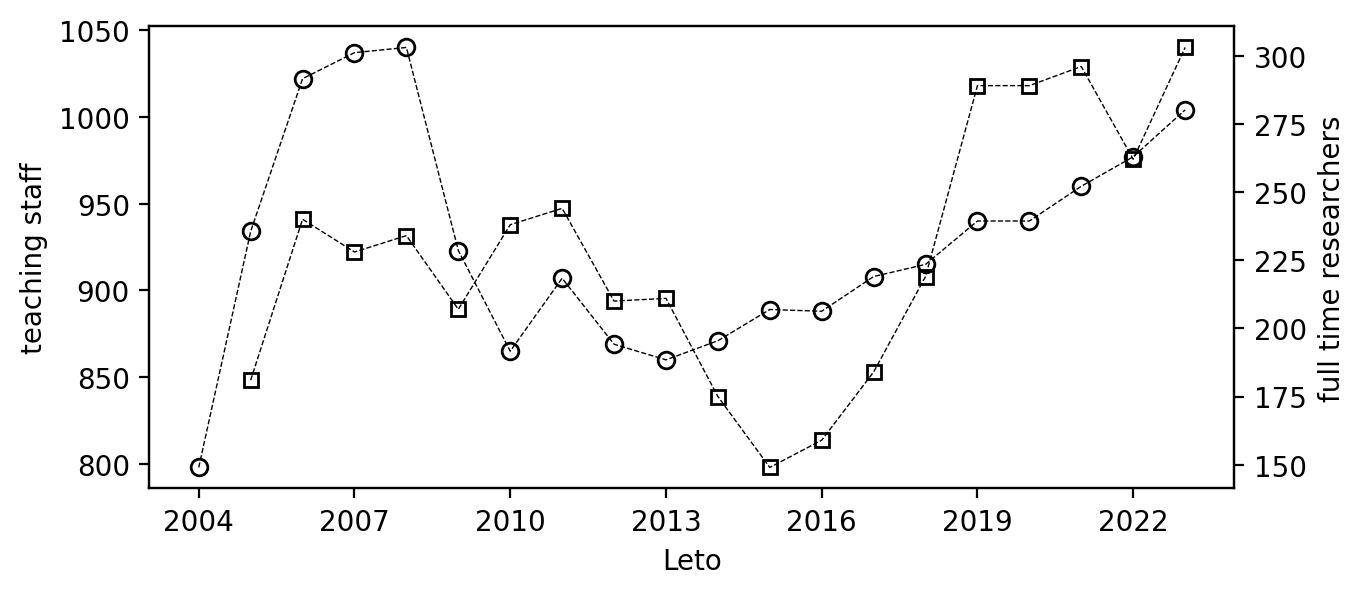

In [41]:
# plot um_staff and um_skupina_H from 2005 to 2023
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
ax1.plot(list(um_staff.keys()), list(um_staff.values()), marker='o', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=6)
ax2.plot(list(um_skupina_H.keys()), list(um_skupina_H.values()), marker='s', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=5)
# x ticks integer
plt.xticks(np.arange(2004, 2024, 3));
ax1.set_xlabel('Leto')
ax1.set_ylabel('teaching staff', color='black')
ax2.set_ylabel('full time researchers', color='black')
# add arrows indicating to which axis the points belong
ax1.annotate('', xy=(2010, 865), xytext=(2010, 865), arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate('', xy=(2010, 238), xytext=(2010, 238), arrowprops=dict(facecolor='black', shrink=0.05))


#ax1.legend(["teaching staff"], loc='lower right')
#ax2.legend(["full time researchers"], loc='upper right')


In [43]:
# partial sum of um_staff and um_skupina_H over 5 year overlapping windows
um_staff_sum = {}
um_skupina_H_sum = {}
um_research_sum = {}
for year in range(2009, 2024):
    um_staff_sum[year] = sum([um_staff[y] for y in range(year-4, year+1)])
    um_skupina_H_sum[year] = sum([um_skupina_H[y] for y in range(year-4, year+1)])
    um_research_sum[year] = sum([um_research[y] for y in range(year-4, year+1)])

Text(0, 0.5, 'full time researchers')

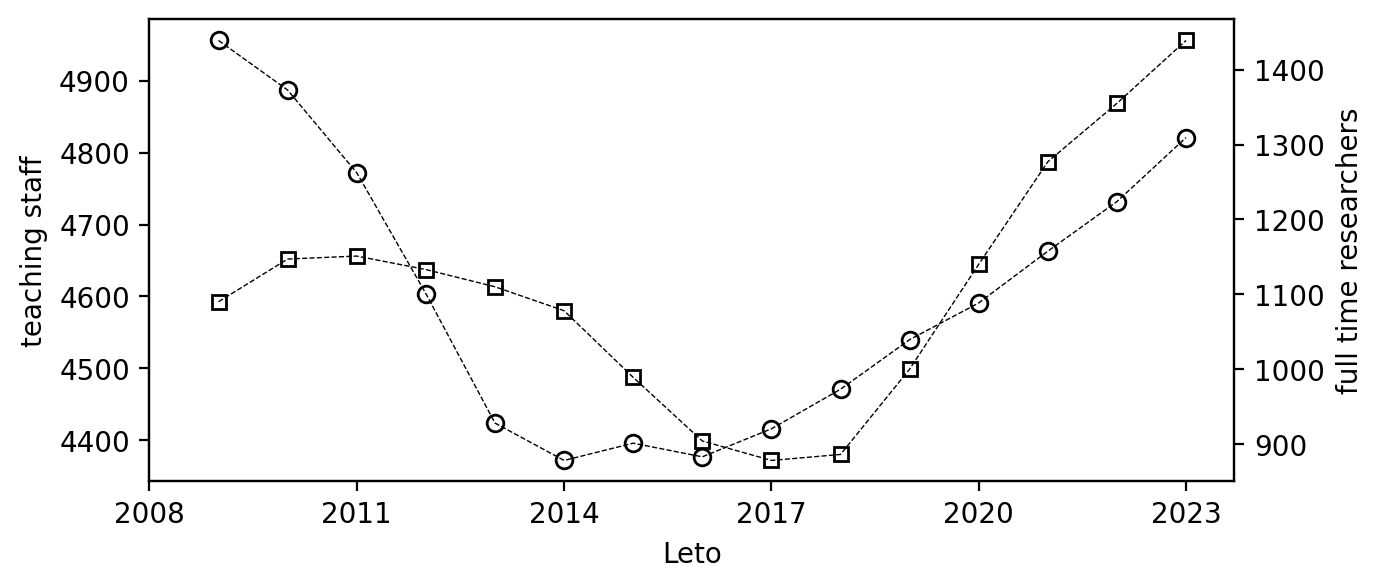

In [ ]:
# plot um_staff_sum and um_skupina_H_sum from 2009 to 2023
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
ax1.plot(list(um_staff_sum.keys()), list(um_staff_sum.values()), marker='o', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=6)
ax2.plot(list(um_skupina_H_sum.keys()), list(um_skupina_H_sum.values()), marker='s', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=5)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
ax1.set_xlabel('Leto')
ax1.set_ylabel('teaching staff', color='black')
ax2.set_ylabel('full time researchers', color='black')


Text(0, 0.5, 'researchers')

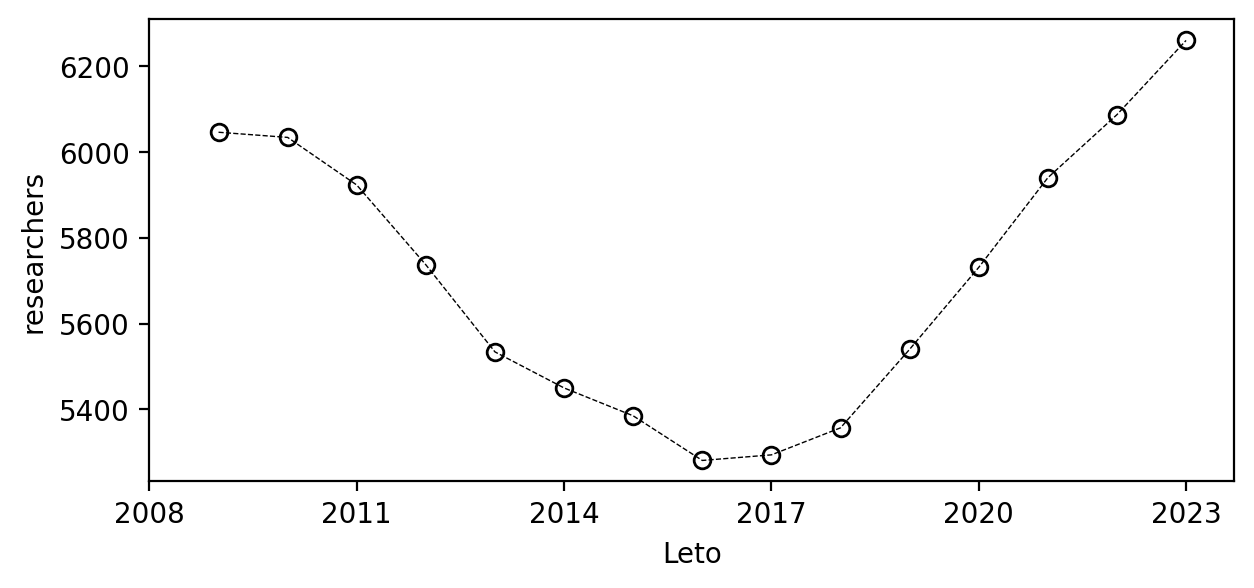

In [45]:
# plot um_research_sum from 2009 to 2023
plt.figure(figsize=(7, 3))
plt.plot(list(um_research_sum.keys()), list(um_research_sum.values()), marker='o', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=6)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
plt.xlabel('Leto')
plt.ylabel('researchers')


Text(0, 0.5, 'full time researchers rate')

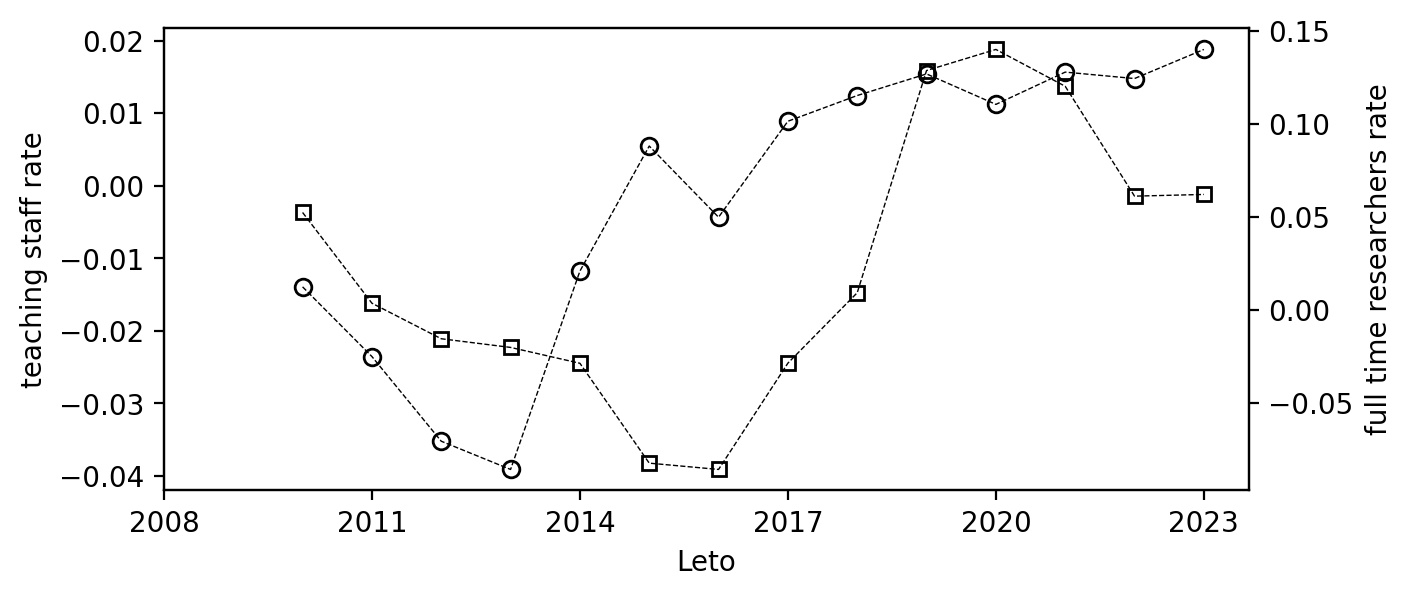

In [47]:
# plot rate of change of um_staff and um_skupina_H from 2009 to 2023
um_staff_rate = {}
um_skupina_H_rate = {}
um_research_rate = {}
for year in range(2010, 2024):
    um_staff_rate[year] = (um_staff_sum[year] - um_staff_sum[year-1])/um_staff_sum[year-1]
    um_skupina_H_rate[year] = (um_skupina_H_sum[year] - um_skupina_H_sum[year-1])/um_skupina_H_sum[year-1]
    um_research_rate[year] = (um_research_sum[year] - um_research_sum[year-1])/um_research_sum[year-1]

# plot um_staff_rate and um_skupina_H_rate from 2009 to 2023
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
ax1.plot(list(um_staff_rate.keys()), list(um_staff_rate.values()), marker='o', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=6)
ax2.plot(list(um_skupina_H_rate.keys()), list(um_skupina_H_rate.values()), marker='s', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=5)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
ax1.set_xlabel('Leto')
ax1.set_ylabel('teaching staff rate', color='black')
ax2.set_ylabel('full time researchers rate', color='black')


Text(0, 0.5, 'researchers rate')

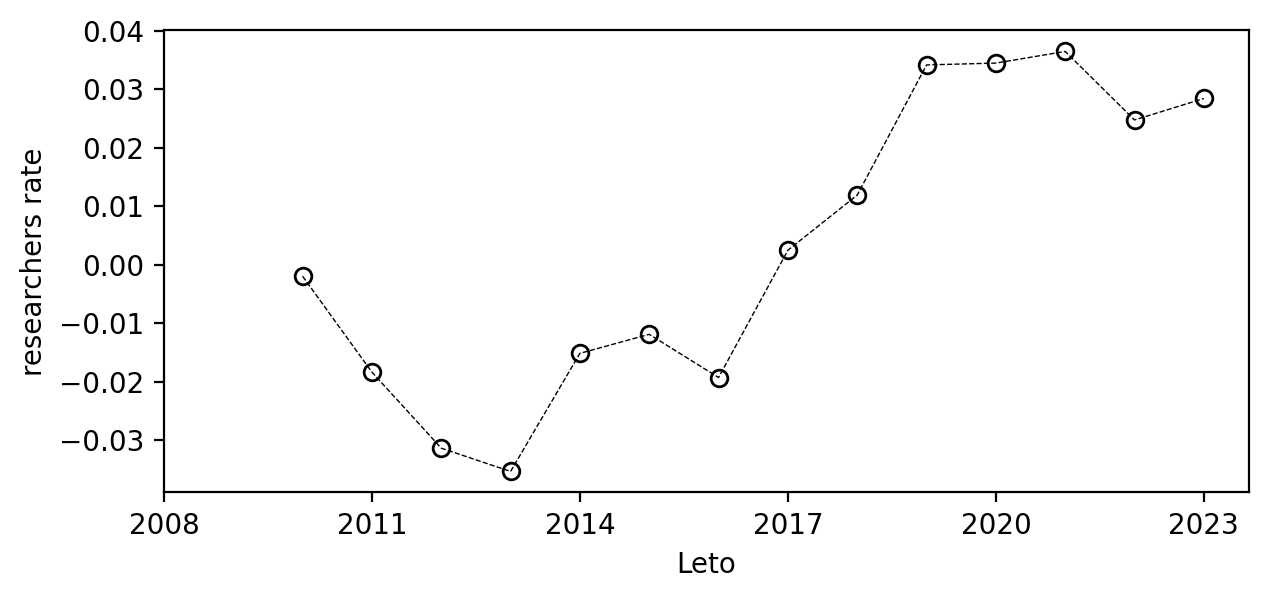

In [48]:
# plot um_research_rate from 2009 to 2023
plt.figure(figsize=(7, 3))
plt.plot(list(um_research_rate.keys()), list(um_research_rate.values()), marker='o', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=6)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
plt.xlabel('Leto')
plt.ylabel('researchers rate')


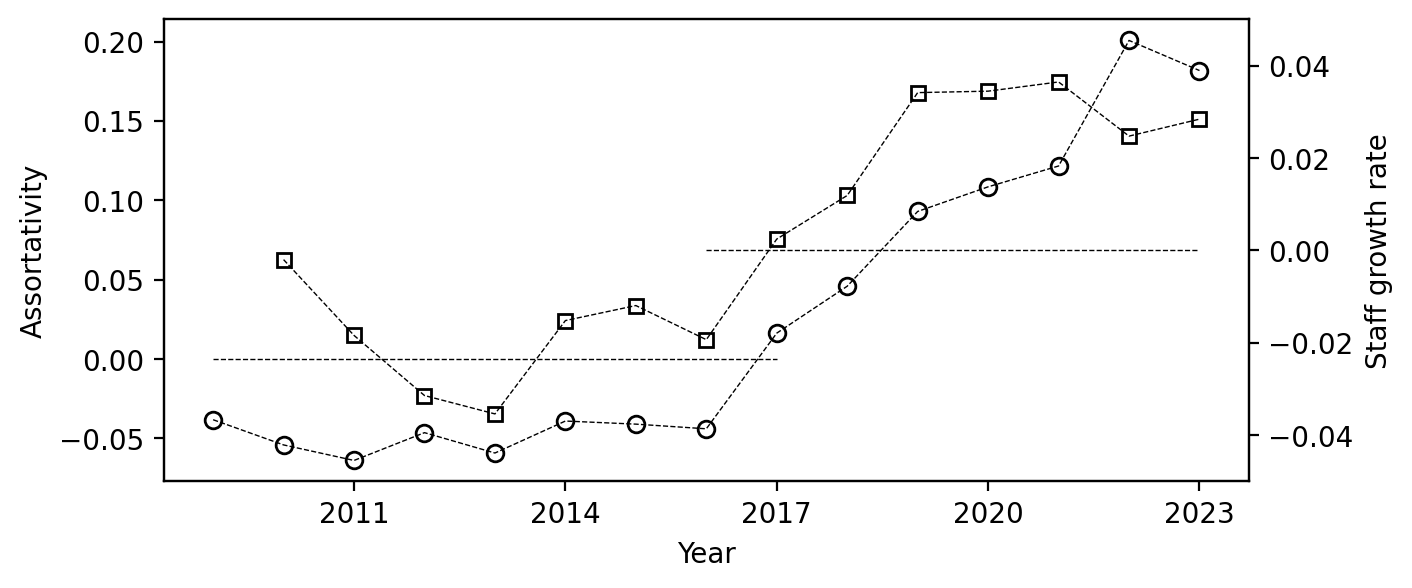

In [58]:
# plot assortativity and research rate from 2009 to 2023
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
ax1.plot(xx, r, label='Assortativity', color='black', linestyle='dashed', linewidth=0.5, marker='o', markersize=6, mfc="none")
ax2.plot(list(um_research_rate.keys()), list(um_research_rate.values()), marker='s', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=5)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
ax1.set_xlabel('Year')
ax1.set_ylabel('Assortativity', color='black')
ax2.set_ylabel('Staff growth rate', color='black')
ax2.set_ylim(-0.05, 0.05)

# Define x limits
x_start = 2009
x_end = 2017
y_value = 0

# Plot the horizontal line
ax1.hlines(y=y_value, xmin=x_start, xmax=x_end, colors='black', linestyles='dashed',lw=0.5)
ax2.hlines(y=y_value, xmin=x_start+7, xmax=x_end+6, colors='black', linestyles='dashed',lw=0.5)



In [60]:
# compute assortativity and research rate from 2009 to 2023 and clustering coefficient, all normalized to 0-1
r_norm = [(r[i] - min(r))/(max(r) - min(r)) for i in range(len(r))]
c_norm = [(c[i] - min(c))/(max(c) - min(c)) for i in range(len(c))]
um_research_rate_norm = [(um_research_rate[year] - min(um_research_rate.values()))/(max(um_research_rate.values()) - min(um_research_rate.values())) 
for year in range(2010, 2024)]

Text(0, 0.5, 'Normalized values')

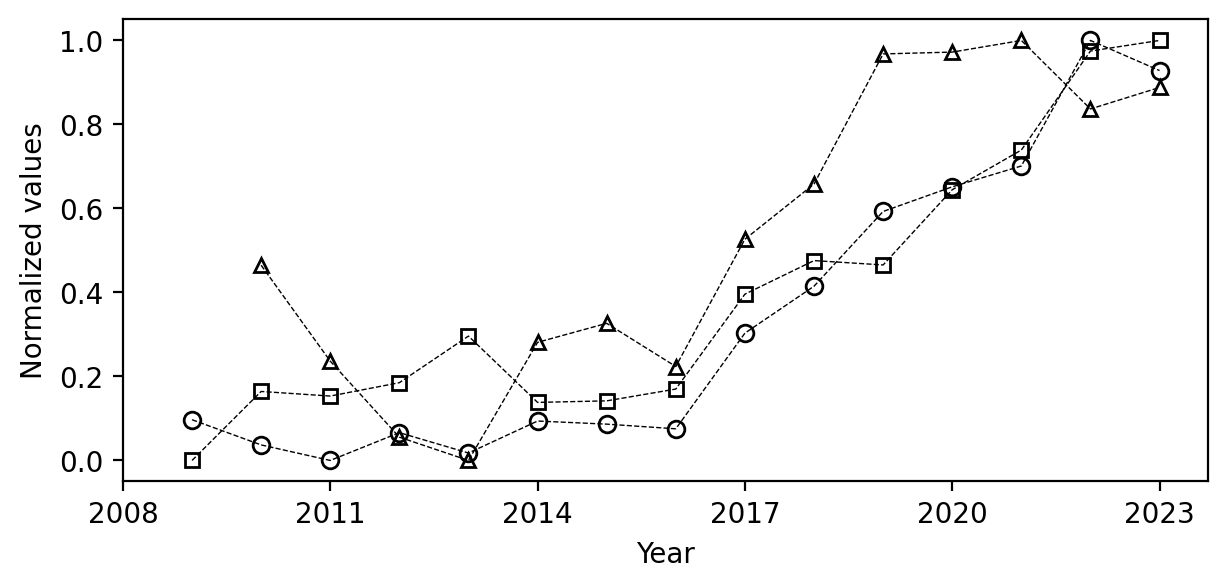

In [62]:
# plot r_norm, c_norm and um_research_rate_norm from 2009 to 2023
fig, ax1 = plt.subplots(figsize=(7, 3))
ax1.plot(xx, r_norm, label='Assortativity', color='black', linestyle='dashed', linewidth=0.5, marker='o', markersize=6, mfc="none")
ax1.plot(xx, c_norm, label='Clustering coefficient', color='black', linestyle='dashed', linewidth=0.5, marker='s', markersize=5, mfc="none")
ax1.plot(xx[1:],um_research_rate_norm, marker='^', color='black', linestyle='--', linewidth=.5, mfc = 'none', ms=5)
# x ticks integer
plt.xticks(np.arange(2008, 2024, 3));
ax1.set_xlabel('Year')
ax1.set_ylabel('Normalized values', color='black')